# Denoising autoencoders with Keras, TensorFlow, and Deep Learning
https://www.pyimagesearch.com/2020/02/24/denoising-autoencoders-with-keras-tensorflow-and-deep-learning/
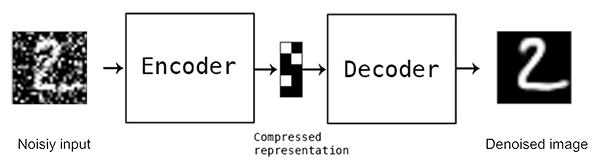

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

## Autoencoder definition

In [2]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16):
        """
        Args:
            width: Width of the input image in pixels.
            height: Heigh of the input image in pixels.
            depth: Number of channels (i.e., depth) of the input volume.
            filters: A tuple that contains the set of filters for convolution operations.
             By default, if this parameter is not provided by the caller, we’ll add two sets of
             CONV => RELU => BN with 32 and 64 filters.
            latentDim: The number of neurons in our fully-connected (Dense) latent vector (number of elements
             used to compress our input image).
        """
        # Initialize the input shape to be "channels last" along with the channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1
        
        # Define the input to the encoder
        inputs = Input(shape=inputShape)
        x = inputs
        
        # Loop over the number of filters
        for f in filters:
            # Apply a CONV => RELU => BN operation
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        
        # Flatten the network and then construct our latent vector
        volumeSize = K.int_shape(x)  # Returns the shape of tensor or variable as a tuple of int or None entries
        x = Flatten()(x)
        latent = Dense(latentDim)(x)
        
        # Build the encoder model
        encoder = Model(inputs, latent, name="encoder")
        
        # Start building the decoder model which will accept the output of the encoder as its inputs
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        
        # Loop over our number of filters again, but this time in reverse order
        for f in filters[::-1]:
            # Apply a CONV_TRANSPOSE => RELU => BN operation
            x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
            
        # Apply a single CONV_TRANSPOSE layer used to recover the original depth of the image
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)
        
        # Build the decoder model
        decoder = Model(latentInputs, outputs, name="decoder")
        
        # Our autoencoder is the encoder + decoder
        autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
        
        # Return a 3-tuple of the encoder, decoder, and autoencoder
        return (encoder, decoder, autoencoder)

## Settings

In [3]:
samples = 10  # number of samples to visualize when decoding

# Initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 32

## Preprocessing

In [4]:
# Load the MNIST dataset
((trainX, _), (testX, _)) = mnist.load_data()

# Add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# Sample noise from a random normal distribution centered at 0.5 (since
# our images lie in the range [0, 1]) and a standard deviation of 0.5
trainNoise = np.random.normal(loc=0.5, scale=0.5, size=trainX.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size=testX.shape)
trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

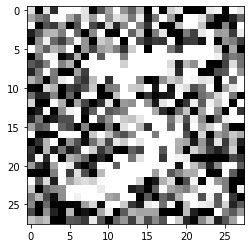

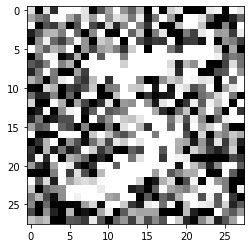

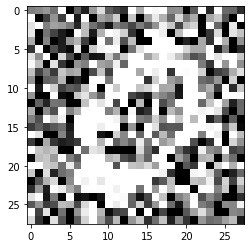

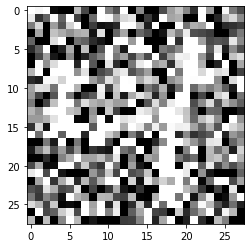

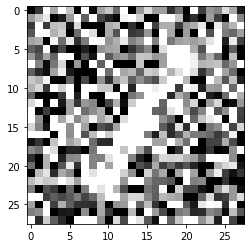

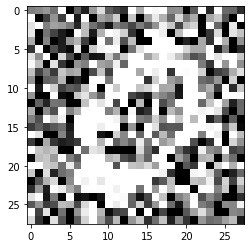

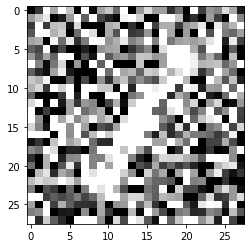

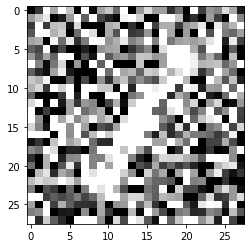

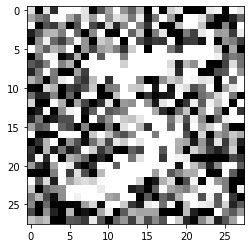

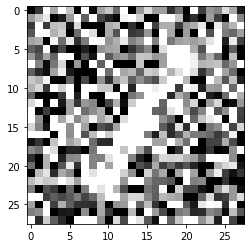

In [5]:
# Show the noisy images
imgs = trainXNoisy.copy()
random.shuffle(imgs)

for i in range(samples):
    plt.figure()
    plt.imshow(imgs[i, ..., 0], cmap='gray')

## Training

In [6]:
# Construct our convolutional autoencoder
# We will be minimizing the difference between the output of the network and trainX (the images without noise)
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

# Train the convolutional autoencoder
H = autoencoder.fit(trainXNoisy, trainX, validation_data=(testXNoisy, testX), epochs=EPOCHS, batch_size=BS)

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 33s 545us/sample - loss: 0.0277 - val_loss: 0.0197
Epoch 2/25
60000/60000 [==============================] - 33s 552us/sample - loss: 0.0187 - val_loss: 0.0190
Epoch 3/25
60000/60000 [==============================] - 34s 560us/sample - loss: 0.0177 - val_loss: 0.0169
Epoch 4/25
60000/60000 [==============================] - 34s 563us/sample - loss: 0.0171 - val_loss: 0.0170
Epoch 5/25
60000/60000 [==============================] - 34s 569us/sample - loss: 0.0167 - val_loss: 0.0166
Epoch 6/25
60000/60000 [==============================] - 34s 571us/sample - loss: 0.0163 - val_loss: 0.0165
Epoch 7/25
60000/60000 [==============================] - 35s 575us/sample - loss: 0.0161 - val_loss: 0.0162
Epoch 8/25
60000/60000 [==============================] - 35s 576us/sample - loss: 0.0159 - val_loss: 0.0166
Epoch 9/25
60000/60000 [==============================] - 35s 579us/sample - l

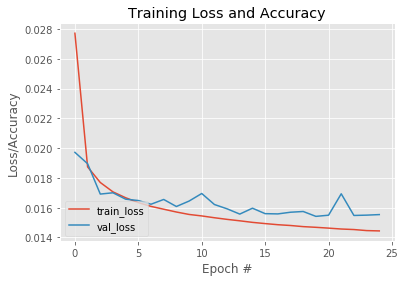

In [7]:
# Construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

## Testing the denoiser

(-0.5, 55.5, 279.5, -0.5)

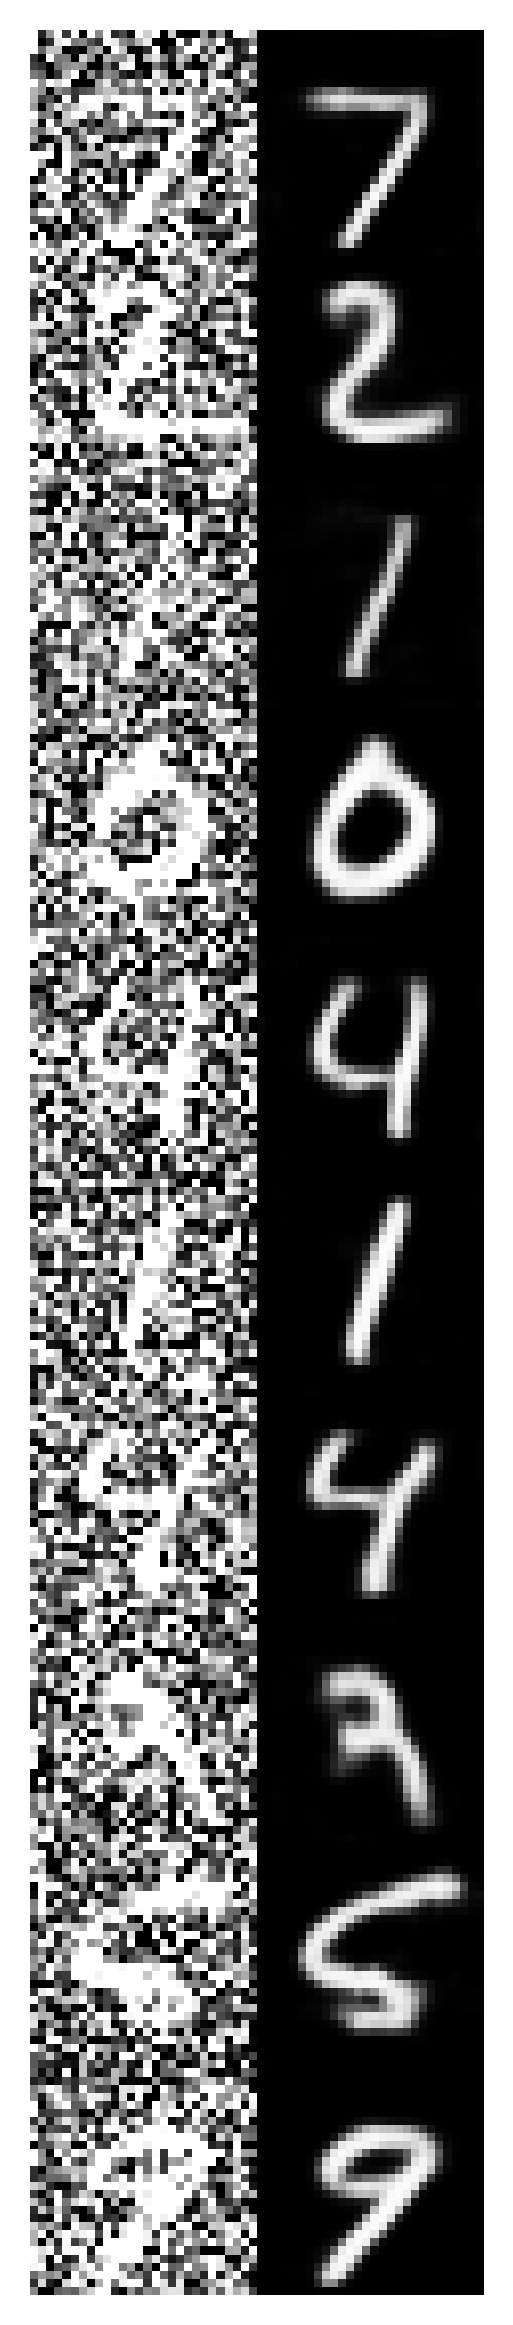

In [8]:
# Use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
decoded = autoencoder.predict(testXNoisy)
outputs = None

# Loop over our number of output samples
for i in range(0, samples):
    # Grab the original image and reconstructed image
    original = (testXNoisy[i] * 255).astype("uint8")
    recon = (decoded[i] * 255).astype("uint8")
    
    # Stack the original and reconstructed image side-by-side
    output = np.hstack([original, recon])
    
    # If the outputs array is empty, initialize it as the current side-by-side image display
    if outputs is None:
        outputs = output
        
    # Otherwise, vertically stack the outputs
    else:
        outputs = np.vstack([outputs, output])

# Show immages
fig = plt.figure(figsize=(10, 10), dpi=300)
plt.imshow(outputs[..., 0], cmap='gray')
plt.axis('off')